In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

# Segmentation and boundary-box regression

TODO: 
* Load model
* Plot intensity distribution
* Evaluate a good threshold (Weakly Supervised Deep Learning for Segmentationof Remote Sensing Imagery)

Some help:
https://stackoverflow.com/questions/64617205/merging-each-instance-mask-back-to-the-original-image-python
https://stackoverflow.com/questions/61383095/create-mask-or-boundary-from-each-other-in-python3

In [2]:
from src.utils.preprocess import tensor2numpy, image2axial,mask_threshold
from src.utils.utils import split_custom_filename
from src.segmentation import cam
from src.classifier.agent import load_trainer
from src.segmentation.cam import CAMS
from src.segmentation import segmentation
import nibabel as nib


import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt

In [3]:
# Load models
trainer, dataset, model = load_trainer('resnet50', checkpoint_path="/logs/tb/resnet50/version_16/checkpoints/checkpoint-v1.ckpt");
cam_extractor = cam.CAM(CAMS.SmoothGradCAMpp.value, model)

# Load example image
filename= '../data/SPM_categorised/AIH/CN/CN_ADNI_0443.nii'
#filename = '../data/SPM_categorised/AIH/AD/AD_ADNI_2491.nii'
#filename = '../data/SPM_categorised/AIH/AD/AD_ADNI_2526.nii'
class_label = split_custom_filename(filename,'/')[4]
test_image = image2axial(nib.load(filename).get_fdata())

Loading model from /home/stud1/f/fremar16/Master_thesis/logs/tb/resnet50/version_16/checkpoints/checkpoint-v1.ckpt (checkpoint)..
Architecture [ResNet] was created
***Defined hyperparameters:***
"arch":                {'name': 'resnet50', 'args': {'num_channels': 1, 'num_classes': 3}}
"callbacks":           ['litprogressbar', 'modelcheckpoints', 'metriccallback']
"class_weights":       None
"hp_metrics":          ['loss/train', 'loss/val', 'accuracy/val', 'auc/val', 'specificity/val', 'sensitivity/val']
"kfold":               {'enable': False, 'folds': 10}
"loss":                CrossEntropyLoss
"loss_weight_balance": None
"optimizer":           {'type': 'Adam', 'args': {'lr': 0.0002, 'weight_decay': 2e-05, 'amsgrad': False}}
"roi_enabled":         False
"roi_hparams":         {'enable': False, 'output_shape': [40, 40, 40], 'boundary_boxes': []}
Dataset sizes - Training: 421 Validation: 47


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


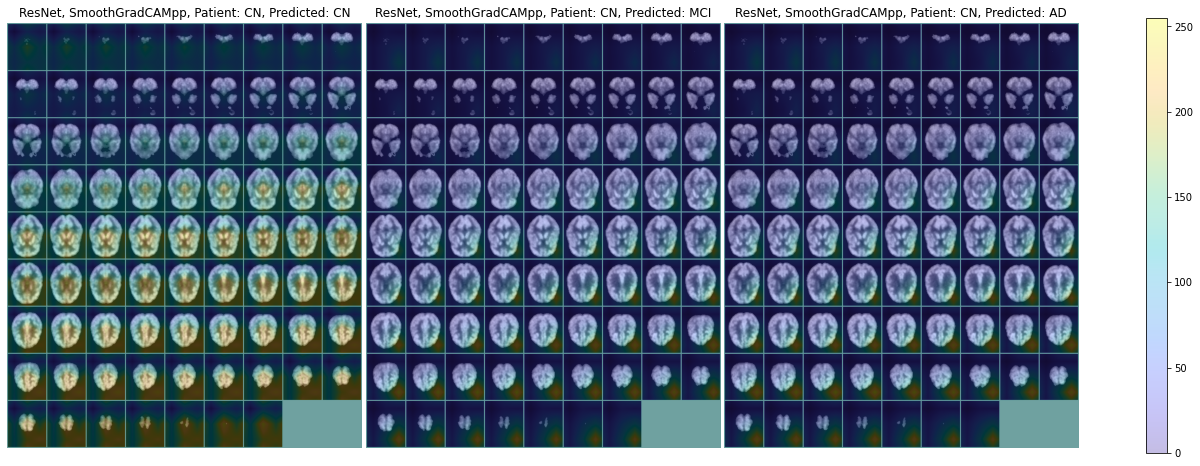

In [4]:
class_scores, class_idx = cam_extractor.evaluate(test_image)
grid_image, grid_mask = cam_extractor.grid_class(class_scores, [0,1,2], test_image,pad_value=0, max_num_slices=None)
masked_image = cam_extractor.preprocess(cam_extractor.activation_map(class_idx, class_scores))
cam_extractor.plot(class_scores, [0,1,2],test_image, max_num_slices=None, class_label=class_label);


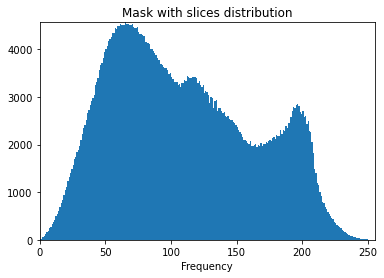

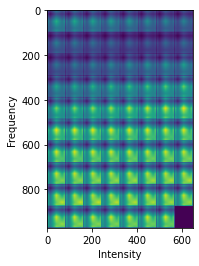

In [5]:
# Only check the distribution from each image! This looks a lot better!
sliced_masks = cam_extractor.preprocess(cam_extractor.activation_map(0, class_scores))

#segmentation.intensity_distribution(sliced_masks[30].flatten(),title="Mask with slices distribution")
segmentation.intensity_distribution(sliced_masks.flatten(),title="Mask with slices distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.imshow(torchvision.utils.make_grid(torch.from_numpy(sliced_masks).unsqueeze(1), nrow=8)[0])

# Extract Segmentation and boundary boxes

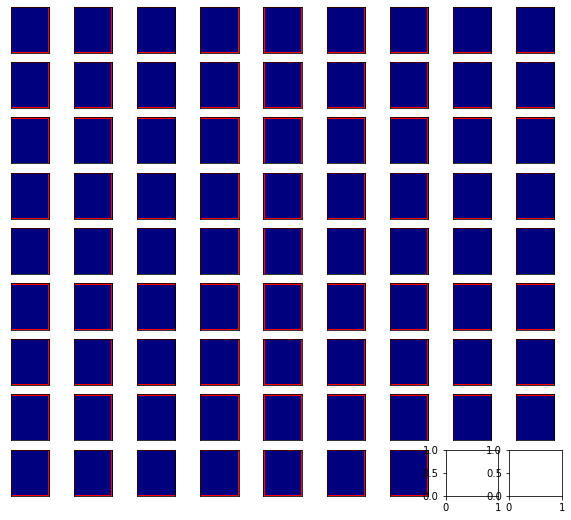

In [6]:
features = segmentation.sequential_processing(test_image, sliced_masks)

# RoIAlign

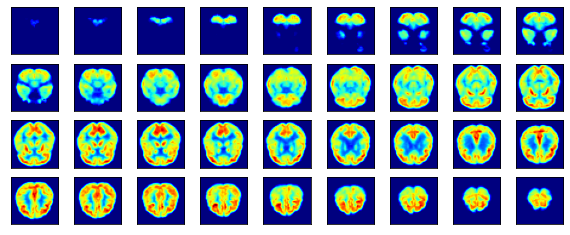

In [7]:
derp = segmentation.roi_align(test_image, segmentation.bounding_boxes(features), displayed=True)

## Extract all regions

In [36]:
from src.classifier.dataloader.dataset import AdniDataset
from src.utils import load
import src
from src.segmentation.segmentation import RoiTransform
import itertools
from skimage import measure
import matplotlib.patches as mpatches
import seaborn as sns
import ast
# Load a dataloader here!
files = load.load_files(src.BASEDIR + "/"+"data/SPM_categorised/AIH")
fileset = AdniDataset(files)

def feature_extraction(cam_extractor, thread_workers=20):
    from concurrent.futures import ThreadPoolExecutor
    content = itertools.product(enumerate(fileset),[0,1,2])
    lambda1 = 1
    lambda2 = 1
    min_pixels = 10
    def inner(data):
        i, nifti_image, patient_class, observe_class = data
        
        image_name = fileset.data[i].rsplit("/",1)[1]
        nifti_image = nifti_image.squeeze(0)
        np_image = tensor2numpy(nifti_image)*255
        
        class_scores, class_idx = cam_extractor.evaluate(nifti_image)
        image_mask = cam_extractor.preprocess(cam_extractor.activation_map(observe_class, class_scores))
        #print(image_mask)
        
        # Remove mask that we know are a background (not a jpart of the brain scan)
        #mask_no_background = segmentation.remove_known_background_from_mask(image, image_mask)

        upper_bound = np.quantile(image_mask, 0.85)
        lower_bound = np.quantile(image_mask, 0.5)
        
        segmented_mask = segmentation.segment_mask(np_image, image_mask, upper_bound=upper_bound, lower_bound=lower_bound) 
        
        print(f"Image: {image_name}, Patient: {patient_class}, Observe: {observe_class}, Model predict: {class_idx}", end='\r')
        # TODO is it bbox_area or area
        features = measure.regionprops(segmented_mask, intensity_image=image_mask)
        new_features = {
            'bbox_area':[feature.bbox_area for feature in features], 
            'mean_intensity':[feature.mean_intensity for feature in features], 
            'bbox':segmentation.bounding_boxes(features),
        }
        new_features.update({
            'score':lambda1 * np.mean(new_features['mean_intensity'])/np.mean(image_mask) - lambda2*((np.array(new_features['bbox_area']))/image_mask.size)
        })
        
        del class_scores, nifti_image, segmented_mask, image_mask, features
        return {'image':image_name, 'patient_class':patient_class, 'observe_class':observe_class, 'probability_class':class_idx, **new_features} 

    with ThreadPoolExecutor(max_workers=thread_workers) as executor:
        results = executor.map(inner,((i, image, patient_class, observe_class) for (i, (image, patient_class)), observe_class in content))
    #[inner((i, image, patient_class, observe_class)) for (i, (image, patient_class)), observe_class in content]
    # [(i, image, patient_class, observe_class) for (i, (image, patient_class)), observe_class in content]
    return results

## Boundary boxes to pandas list

In [37]:
bboxes_dict = list(feature_extraction(cam_extractor, thread_workers=20))

/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Image: AD_ADNI_2513.nii, Patient: 2, Observe: 2, Model predict: 2Image: AD_ADNI_2803.nii, Patient: 2, Observe: 0, Model predict: 2Image: AD_ADNI_2866.nii, Patient: 2, Observe: 0, Model predict: 2

/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
bboxes_dict[3]

{'image': 'AD_ADNI_2866.nii',
 'patient_class': 2,
 'observe_class': 0,
 'probability_class': 2,
 'bbox_area': [480, 32830, 353400, 21504, 1],
 'mean_intensity': [61.18232044198895,
  76.73976041072447,
  115.13996831680159,
  67.80264658909422,
  59.0],
 'bbox': [(39, 0, 79, 4, 0, 3),
  (30, 28, 79, 95, 0, 10),
  (19, 0, 79, 95, 17, 79),
  (0, 31, 7, 95, 31, 79),
  (0, 0, 1, 1, 39, 40)],
 'score': array([1.05547138, 1.0009086 , 0.46022264, 1.02001147, 1.05624892])}

In [42]:
# Convert data to dataframe
import pandas as pd
bboxes_df = pd.DataFrame(bboxes_dict)
bboxes_df.rename(columns = {'index' : 'image', 'bbox':'bbox'}, inplace = True)
bboxes_df['bbox_count'] = bboxes_df['bbox'].str.len()
bboxes_df = bboxes_df[bboxes_df['bbox_count']>0]
bboxes_df = bboxes_df.apply(pd.Series.explode)
#bboxes_df['bbox'] = column_to_np(column_to_tuple(bboxes_df['bbox']))#column_to_np(bboxes_df['bbox'], dtype=int)
#bboxes_df.rename(columns = {'index' : 'Image_class'}, inplace = True)
bboxes_df.reset_index(inplace = True)
bboxes_df.rename(columns = {'index' : 'Image_class'}, inplace = True)
bboxes_df.head(20)


Image_class             image  patient_class  observe_class  \
0             0  AD_ADNI_2523.nii              2              0   
1             0  AD_ADNI_2523.nii              2              0   
2             0  AD_ADNI_2523.nii              2              0   
3             0  AD_ADNI_2523.nii              2              0   
4             0  AD_ADNI_2523.nii              2              0   
5             1  AD_ADNI_2523.nii              2              1   
6             1  AD_ADNI_2523.nii              2              1   
7             2  AD_ADNI_2523.nii              2              2   
8             2  AD_ADNI_2523.nii              2              2   
9             2  AD_ADNI_2523.nii              2              2   
10            2  AD_ADNI_2523.nii              2              2   
11            2  AD_ADNI_2523.nii              2              2   
12            3  AD_ADNI_2866.nii              2              0   
13            3  AD_ADNI_2866.nii              2              0   
14            3  AD_ADNI_2866.nii              2              0   
15            3  AD_ADNI_2866.nii              2              0   
16            3  AD_ADNI_2866.nii              2              0   
17            4  AD_ADNI_2866.nii              2              1   
18            4  AD_ADNI_2866.nii              2              1   
19            4  AD_ADNI_2866.nii              2              1   

    probability_class bbox_area mean_intensity                     bbox  \
0                   2     93483       53.63291  (14, 48, 65, 95, 0, 39)   
1                   2     22724      30.085586   (0, 49, 13, 95, 0, 38)   
2                   2     22724      30.085586  (66, 49, 79, 95, 0, 38)   
3                   2    240825      37.154363   (0, 0, 65, 95, 40, 79)   
4                   2     20520      22.672124  (67, 0, 79, 45, 41, 79)   
5                   2    472815     104.788893   (16, 0, 79, 95, 0, 79)   
6                   2     30500      67.437547  (0, 34, 10, 95, 29, 79)   
7                   2     93483       53.63291  (14, 48, 65, 95, 0, 39)   
8                   2     22724      30.085586   (0, 49, 13, 95, 0, 38)   
9                   2     22724      30.085586  (66, 49, 79, 95, 0, 38)   
10                  2    240825      37.154363   (0, 0, 65, 95, 40, 79)   
11                  2     20520      22.672124  (67, 0, 79, 45, 41, 79)   
12                  2       480       61.18232     (39, 0, 79, 4, 0, 3)   
13                  2     32830       76.73976  (30, 28, 79, 95, 0, 10)   
14                  2    353400     115.139968  (19, 0, 79, 95, 17, 79)   
15                  2     21504      67.802647   (0, 31, 7, 95, 31, 79)   
16                  2         1           59.0     (0, 0, 1, 1, 39, 40)   
17                  2       180      79.833333     (36, 0, 48, 5, 0, 3)   
18                  2     41140      94.686031  (24, 27, 79, 95, 0, 11)   
19                  2        36      78.833333     (0, 45, 2, 54, 0, 2)   

       score  bbox_count  
0   1.558513           5  
1   1.677858           5  
2   1.677858           5  
3       1.31           5  
4   1.681575           5  
5   0.469832           2  
6   1.215858           2  
7   1.558513           5  
8   1.677858           5  
9   1.677858           5  
10      1.31           5  
11  1.681575           5  
12  1.055471           5  
13  1.000909           5  
14  0.460223           5  
15  1.020011           5  
16  1.056249           5  
17  1.047302           7  
18  0.978217           7  
19  1.047545           7

In [43]:
# Save to logs
from datetime import datetime
now = datetime.now()
name = f'../logs/bounding_boxes{now}.csv'
bboxes_df.to_csv(name,index=False,header=True)

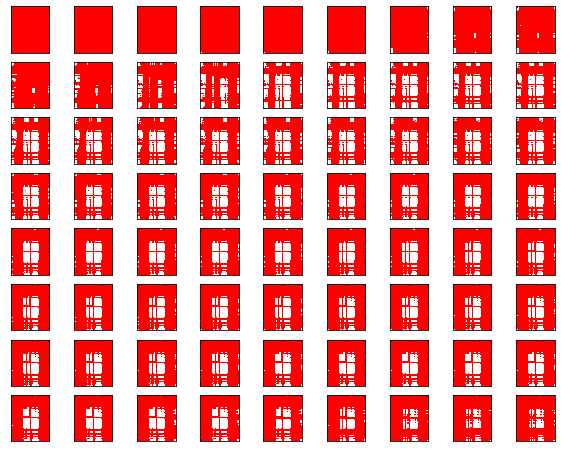

In [44]:
# Plot all bounding boxes on an image
from matplotlib import colors
image = segmentation.add_image_bboxes(np.zeros((79,95,79)), bboxes_df['bbox'].values.tolist())
fig = segmentation.display(image, step=1,cmap=colors.ListedColormap(['white', 'red']))

In [45]:
bboxes_df

Image_class             image  patient_class  observe_class  \
0               0  AD_ADNI_2523.nii              2              0   
1               0  AD_ADNI_2523.nii              2              0   
2               0  AD_ADNI_2523.nii              2              0   
3               0  AD_ADNI_2523.nii              2              0   
4               0  AD_ADNI_2523.nii              2              0   
...           ...               ...            ...            ...   
5823         1402  CN_ADNI_0508.nii              0              1   
5824         1402  CN_ADNI_0508.nii              0              1   
5825         1403  CN_ADNI_0508.nii              0              2   
5826         1403  CN_ADNI_0508.nii              0              2   
5827         1403  CN_ADNI_0508.nii              0              2   

      probability_class bbox_area mean_intensity                     bbox  \
0                     2     93483       53.63291  (14, 48, 65, 95, 0, 39)   
1                     2     22724      30.085586   (0, 49, 13, 95, 0, 38)   
2                     2     22724      30.085586  (66, 49, 79, 95, 0, 38)   
3                     2    240825      37.154363   (0, 0, 65, 95, 40, 79)   
4                     2     20520      22.672124  (67, 0, 79, 45, 41, 79)   
...                 ...       ...            ...                      ...   
5823                  2    480320     118.868729   (0, 0, 79, 95, 15, 79)   
5824                  2         6           70.5     (0, 0, 1, 2, 39, 42)   
5825                  2      3069      37.657321    (48, 0, 79, 11, 0, 9)   
5826                  2    457805      83.249833   (18, 0, 79, 95, 0, 79)   
5827                  2     18819      39.266493   (0, 44, 9, 95, 38, 79)   

         score  bbox_count  
0     1.558513           5  
1     1.677858           5  
2     1.677858           5  
3         1.31           5  
4     1.681575           5  
...        ...         ...  
5823  0.353318           3  
5824  1.163421           3  
5825  1.086707           3  
5826  0.319732           3  
5827  1.060143           3  

[5828 rows x 10 columns]

In [46]:
# Get the medium center coordinates. 
#x,y,z = center_coordinates(np.array(bbox_listed))
#max_occurance(x)

In [47]:
# Load content from csv to dataframe
#bboxes_df = pd.read_csv(r'../logs/bounding_boxes2021-04-16 04:27:59.105114.csv', dtype={'patient_class':int, 'observe_class':int,'probability_class':int,'bbox_count':int})
#bboxes_df['bbox'] = segmentation.column_to_np(segmentation.column_to_tuple(bboxes_df['bbox']))
#bboxes_df['centroid'] = column_to_np(pd_to_tuple(bboxes_df['centroid']))

In [17]:
bboxes_df

Image_class             image  patient_class  observe_class  \
0               0  AD_ADNI_2523.nii              2              0   
1               0  AD_ADNI_2523.nii              2              0   
2               0  AD_ADNI_2523.nii              2              0   
3               1  AD_ADNI_2523.nii              2              1   
4               1  AD_ADNI_2523.nii              2              1   
...           ...               ...            ...            ...   
4658         1402  CN_ADNI_0508.nii              0              1   
4659         1402  CN_ADNI_0508.nii              0              1   
4660         1402  CN_ADNI_0508.nii              0              1   
4661         1403  CN_ADNI_0508.nii              0              2   
4662         1403  CN_ADNI_0508.nii              0              2   

      probability_class  bbox_area  mean_intensity  \
0                     2     465310       71.926513   
1                     2        220       20.237113   
2                     2      47025       27.960039   
3                     2     480320       85.314480   
4                     2       1400       32.248214   
...                 ...        ...             ...   
4658                  2     592895       71.546870   
4659                  2        810       30.086758   
4660                  2       4992       31.150402   
4661                  2     592895       74.527029   
4662                  2       1344       33.214118   

                                    bbox     score  bbox_count  
0     [17.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.006031           3  
1       [0.0, 40.0, 2.0, 95.0, 0.0, 2.0]  0.778409           3  
2      [0.0, 0.0, 9.0, 95.0, 24.0, 79.0]  0.699465           3  
3     [15.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.043632           4  
4       [0.0, 39.0, 5.0, 95.0, 0.0, 5.0]  0.764133           4  
...                                  ...       ...         ...  
4658   [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.248434           4  
4659    [0.0, 41.0, 5.0, 95.0, 0.0, 3.0]  0.750199           4  
4660   [0.0, 0.0, 8.0, 13.0, 31.0, 79.0]  0.743146           4  
4661   [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.074568           2  
4662    [0.0, 39.0, 6.0, 95.0, 0.0, 4.0]  0.923165           2  

[4663 rows x 10 columns]

# Check distributions for validating clusters

<AxesSubplot:>

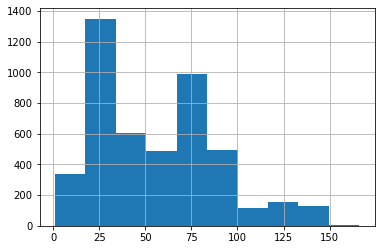

In [18]:
bboxes_df.mean_intensity.hist() # x: snitt intensitet, y: Frekvens

<AxesSubplot:>

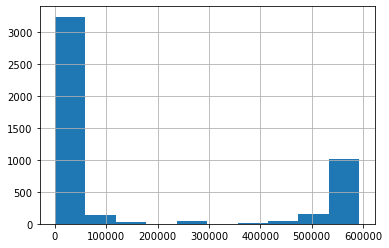

In [19]:
bboxes_df.bbox_area.hist() # x:storlek i pixlar, y: Frekvens

In [20]:
def plot_bbox_category_scatter_upper_bound(bboxes_df):
    cn_bboxes = bboxes_df.loc[(bboxes_df['observe_class'] == 0) & (bboxes_df['patient_class'] == 0) ]
    mci_bboxes = bboxes_df.loc[(bboxes_df['observe_class'] == 1) & (bboxes_df['patient_class'] == 1)]
    ad_bboxes = bboxes_df.loc[(bboxes_df['observe_class'] == 2) & (bboxes_df['patient_class'] == 2)]

    fig = plt.figure()
    plt.title("Relation between area and intensity")
    plt.xlabel("Intensity")
    plt.ylabel("Area")
    plt.scatter(cn_bboxes.mean_intensity,cn_bboxes.bbox_area,color='blue',label='CN',alpha=0.5)
    plt.scatter(mci_bboxes.mean_intensity,mci_bboxes.bbox_area,color='green',label='MCI',alpha=0.5)
    plt.scatter(ad_bboxes.mean_intensity,ad_bboxes.bbox_area,color='purple',label='AD',alpha=0.5)
    #plt.plot((100,240),(0,400000), color='red')
    plt.legend(loc='upper left')
    plt.show()
    return cn_bboxes,mci_bboxes,ad_bboxes

In [21]:
def plot_bbox_category_scatter_lower_bound(bboxes_df):
    cn_bboxes = bboxes_df.loc[(bboxes_df['observe_class'] == 0) & (bboxes_df['patient_class'] == 0) & (bboxes_df['bbox_area'] < 20000)]
    mci_bboxes = bboxes_df.loc[(bboxes_df['observe_class'] == 1) & (bboxes_df['patient_class'] == 1) & (bboxes_df['bbox_area'] <  20000)]
    ad_bboxes = bboxes_df.loc[(bboxes_df['observe_class'] == 2) & (bboxes_df['patient_class'] == 2) & (bboxes_df['bbox_area'] <  20000)]

    fig = plt.figure()
    plt.title("Relation between area and intensity")
    plt.xlabel("Intensity")
    plt.ylabel("Area")
    plt.scatter(cn_bboxes.mean_intensity,cn_bboxes.bbox_area,color='blue',label='CN',alpha=0.5)
    plt.scatter(mci_bboxes.mean_intensity,mci_bboxes.bbox_area,color='green',label='MCI',alpha=0.5)
    plt.scatter(ad_bboxes.mean_intensity,ad_bboxes.bbox_area,color='purple',label='AD',alpha=0.5)
    plt.legend(loc='upper left')
    plt.show()
    return cn_bboxes,mci_bboxes,ad_bboxes

In [22]:
bboxes_df.loc[(bboxes_df['bbox_area'] > 20000) & (bboxes_df['patient_class'] < 170000)]

Image_class             image  patient_class  observe_class  \
0               0  AD_ADNI_2523.nii              2              0   
2               0  AD_ADNI_2523.nii              2              0   
3               1  AD_ADNI_2523.nii              2              1   
5               1  AD_ADNI_2523.nii              2              1   
8               2  AD_ADNI_2523.nii              2              2   
...           ...               ...            ...            ...   
4649         1398  CN_ADNI_0575.nii              0              0   
4653         1399  CN_ADNI_0575.nii              0              1   
4656         1400  CN_ADNI_0575.nii              0              2   
4658         1402  CN_ADNI_0508.nii              0              1   
4661         1403  CN_ADNI_0508.nii              0              2   

      probability_class  bbox_area  mean_intensity  \
0                     2     465310       71.926513   
2                     2      47025       27.960039   
3                     2     480320       85.314480   
5                     2      59565       41.839521   
8                     2     592895       77.513438   
...                 ...        ...             ...   
4649                  0     592895       96.313905   
4653                  0     592895       74.402799   
4656                  0     144495       55.461626   
4658                  2     592895       71.546870   
4661                  2     592895       74.527029   

                                     bbox     score  bbox_count  
0      [17.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.006031           3  
2       [0.0, 0.0, 9.0, 95.0, 24.0, 79.0]  0.699465           3  
3      [15.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.043632           4  
5      [0.0, 0.0, 11.0, 95.0, 22.0, 79.0]  0.666030           4  
8       [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.259835           4  
...                                   ...       ...         ...  
4649    [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.079225           3  
4653    [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.240380           4  
4656  [40.0, 0.0, 79.0, 95.0, 40.0, 79.0]  3.883245           1  
4658    [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.248434           4  
4661    [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.074568           2  

[1561 rows x 10 columns]

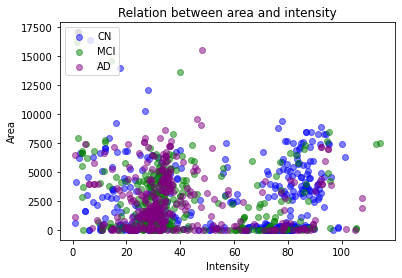

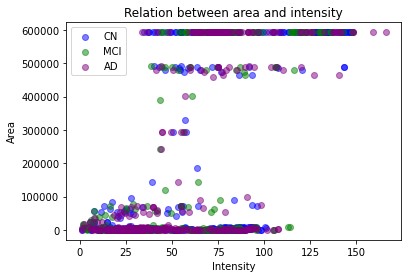

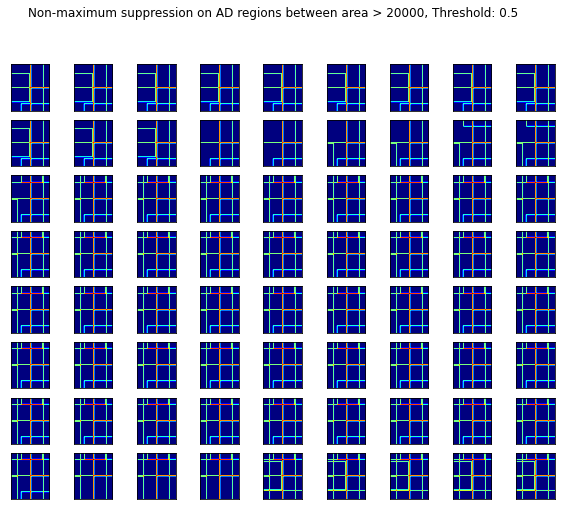

In [23]:
cn_bboxes,mci_bboxes, ad_bboxes = plot_bbox_category_scatter_lower_bound(bboxes_df)
cn_bboxes, mci_bboxes, ad_bboxes = plot_bbox_category_scatter_upper_bound(bboxes_df)
ad_interesting, fig = segmentation.plot_interesting_bbox(ad_bboxes[ad_bboxes['bbox_area'] >20000])
fig.suptitle("Non-maximum suppression on AD regions between area > 20000, Threshold: 0.5")
plt.show()

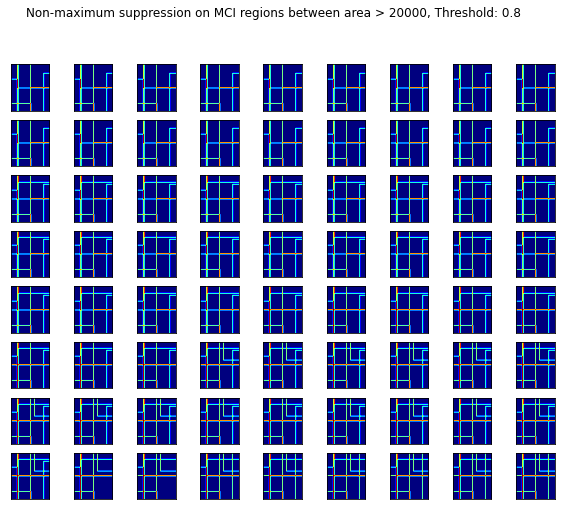

In [24]:
mci_interesting, fig = segmentation.plot_interesting_bbox(mci_bboxes[mci_bboxes['bbox_area'] >20000])
fig.suptitle("Non-maximum suppression on MCI regions between area > 20000, Threshold: 0.8")
plt.show()

In [25]:
mci_bboxes[mci_bboxes['bbox_area'] >2000]

Image_class              image  patient_class  observe_class  \
1492          469  MCI_ADNI_1557.nii              1              1   
1494          469  MCI_ADNI_1557.nii              1              1   
1495          469  MCI_ADNI_1557.nii              1              1   
1505          472  MCI_ADNI_1444.nii              1              1   
1514          475  MCI_ADNI_1465.nii              1              1   
...           ...                ...            ...            ...   
3022          928  MCI_ADNI_1449.nii              1              1   
3024          928  MCI_ADNI_1449.nii              1              1   
3037          934  MCI_ADNI_1408.nii              1              1   
3038          934  MCI_ADNI_1408.nii              1              1   
3040          934  MCI_ADNI_1408.nii              1              1   

      probability_class  bbox_area  mean_intensity  \
1492                  0     592895      142.967587   
1494                  0       7502      114.008283   
1495                  0       7410      112.707717   
1505                  2     592895      122.044393   
1514                  2       6396       40.788177   
...                 ...        ...             ...   
3022                  2     592895       69.102242   
3024                  2       3696       28.939759   
3037                  2       2300       27.066069   
3038                  2     592895       68.210154   
3040                  2       4032       27.417457   

                                      bbox     score  bbox_count  
1492     [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.048053           5  
1494  [68.0, 84.0, 79.0, 95.0, 17.0, 79.0]  0.939294           5  
1495    [0.0, 0.0, 13.0, 10.0, 22.0, 79.0]  0.939449           5  
1505     [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.037023           2  
1514    [38.0, 0.0, 79.0, 13.0, 0.0, 12.0]  0.750980           4  
...                                    ...       ...         ...  
3022     [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.261701           4  
3024     [0.0, 0.0, 7.0, 11.0, 31.0, 79.0]  0.732065           4  
3037     [33.0, 0.0, 79.0, 10.0, 0.0, 5.0]  0.714588           4  
3038     [0.0, 0.0, 79.0, 95.0, 0.0, 79.0] -0.281532           4  
3040     [0.0, 0.0, 7.0, 12.0, 31.0, 79.0]  0.711667           4  

[318 rows x 10 columns]

In [26]:
cn_bboxes[(cn_bboxes['bbox_area'] <10000) & (cn_bboxes['bbox_area'] >1000)]

Image_class             image  patient_class  observe_class  \
3050          939  CN_ADNI_0571.nii              0              0   
3061          942  CN_ADNI_0530.nii              0              0   
3072          945  CN_ADNI_0542.nii              0              0   
3073          945  CN_ADNI_0542.nii              0              0   
3091          951  CN_ADNI_0612.nii              0              0   
...           ...               ...            ...            ...   
4633         1392  CN_ADNI_0608.nii              0              0   
4635         1392  CN_ADNI_0608.nii              0              0   
4639         1395  CN_ADNI_0519.nii              0              0   
4642         1395  CN_ADNI_0519.nii              0              0   
4651         1398  CN_ADNI_0575.nii              0              0   

      probability_class  bbox_area  mean_intensity  \
3050                  0       1968       16.396199   
3061                  0       6700       70.579003   
3072                  2       1001       11.960573   
3073                  2       2952       12.898192   
3091                  0       5600       85.565970   
...                 ...        ...             ...   
4633                  2       4576       95.873514   
4635                  2       7436      100.161437   
4639                  0       3168       92.210383   
4642                  0       7436       95.364348   
4651                  0       2475       59.280728   

                                     bbox     score  bbox_count  
3050     [0.0, 54.0, 8.0, 95.0, 0.0, 6.0]  0.874510           2  
3061  [69.0, 28.0, 79.0, 95.0, 0.0, 10.0]  0.863594           4  
3072    [0.0, 84.0, 7.0, 95.0, 0.0, 13.0]  0.521166           6  
3073     [0.0, 0.0, 8.0, 9.0, 14.0, 55.0]  0.517875           6  
3091   [21.0, 0.0, 61.0, 14.0, 0.0, 10.0]  0.885951           5  
...                                   ...       ...         ...  
4633    [27.0, 0.0, 79.0, 11.0, 0.0, 8.0]  0.950262           3  
4635   [0.0, 0.0, 13.0, 11.0, 27.0, 79.0]  0.945438           3  
4639    [27.0, 0.0, 63.0, 11.0, 0.0, 8.0]  0.879593           4  
4642   [0.0, 0.0, 13.0, 11.0, 27.0, 79.0]  0.872395           4  
4651  [74.0, 17.0, 79.0, 62.0, 0.0, 11.0]  0.916600           3  

[196 rows x 10 columns]

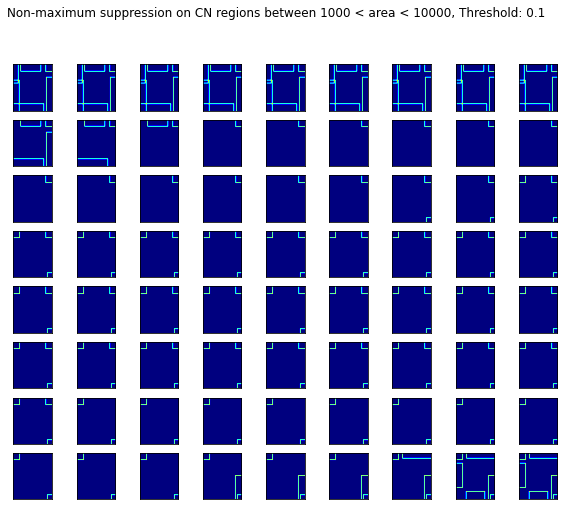

In [27]:
cn_interesting,fig = segmentation.plot_interesting_bbox(cn_bboxes[(cn_bboxes['bbox_area'] <10000) & (cn_bboxes['bbox_area'] >1000)], th=0.1)
fig.suptitle("Non-maximum suppression on CN regions between 1000 < area < 10000, Threshold: 0.1")
plt.show()

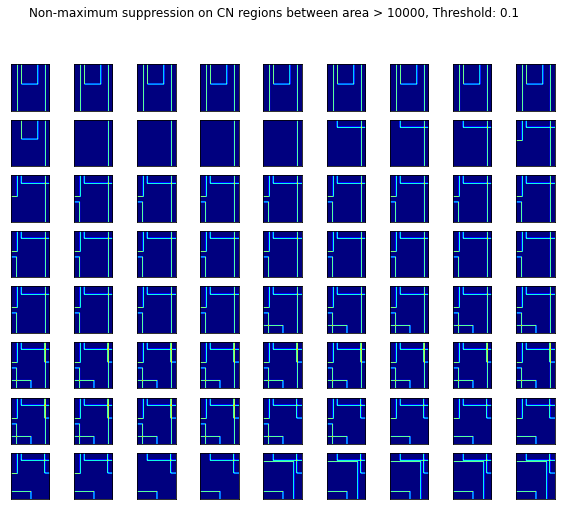

In [28]:
cn_interesting2,fig = segmentation.plot_interesting_bbox(cn_bboxes[(cn_bboxes['bbox_area'] >10000)], th=0.1)
fig.suptitle("Non-maximum suppression on CN regions between area > 10000, Threshold: 0.1")
plt.show()

In [29]:
cn_interesting2

tensor([[ 0.,  0., 79., 95.,  0., 79.],
        [21.,  0., 79., 15., 14., 79.],
        [ 0., 20., 61., 95., 67., 79.],
        [70.,  0., 79., 95.,  0., 58.],
        [ 0., 80., 39., 95., 40., 79.],
        [ 0.,  0., 11., 42., 17., 65.],
        [ 0., 55., 10., 95., 19., 60.],
        [69.,  0., 79., 41., 45., 79.],
        [22.,  0., 53., 39.,  0., 10.],
        [ 0.,  0., 12., 95.,  0.,  9.]])

In [30]:
merge_interesting_boxes = np.stack([*ad_interesting,*mci_interesting,*cn_interesting,*cn_interesting2])
merge_interesting_boxes

array([[ 0.,  0., 79., 95.,  0., 79.],
       [ 0., 48., 79., 95.,  0., 79.],
       [ 0.,  0., 39., 95.,  0., 79.],
       [ 0.,  0., 79., 95., 40., 79.],
       [40.,  0., 79., 95.,  0., 79.],
       [40.,  0., 79., 47.,  0., 79.],
       [66.,  0., 79., 95.,  0., 79.],
       [ 0.,  0., 79., 95.,  0., 12.],
       [ 0.,  0., 79., 76., 67., 79.],
       [40.,  0., 79., 47., 40., 79.],
       [ 0.,  0., 12., 95., 19., 79.],
       [ 0.,  0., 62., 14., 18., 79.],
       [21., 81., 79., 95.,  0., 64.],
       [22.,  0., 79., 13., 16., 79.],
       [ 0., 50., 12., 95., 14., 79.],
       [ 0., 20., 36., 75., 67., 79.],
       [ 0., 20., 36., 75.,  0., 12.],
       [66., 49., 79., 95.,  0., 38.],
       [ 0.,  0., 79., 95.,  0., 79.],
       [40.,  0., 79., 95.,  0., 79.],
       [14.,  0., 79., 47.,  0., 79.],
       [40., 48., 79., 95.,  0., 79.],
       [14., 48., 79., 95., 40., 79.],
       [ 0.,  0., 79., 95.,  0., 12.],
       [ 0.,  0., 64., 95., 66., 79.],
       [ 0.,  0., 13., 95

../src/segmentation/segmentation.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=nrows, ncols=9, figsize=(10, 1*nrows))


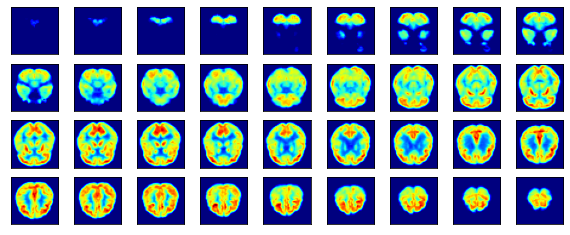

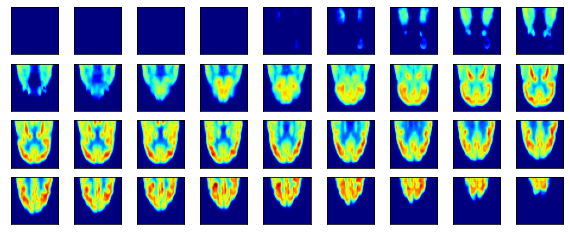

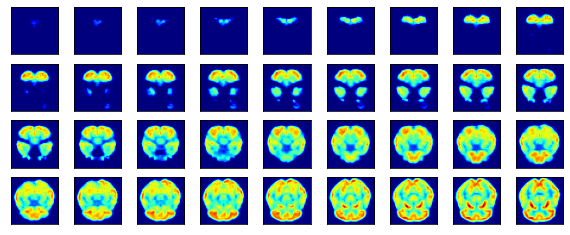

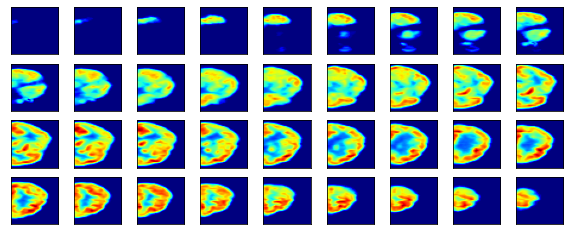

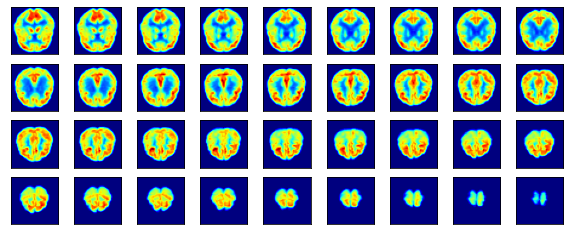

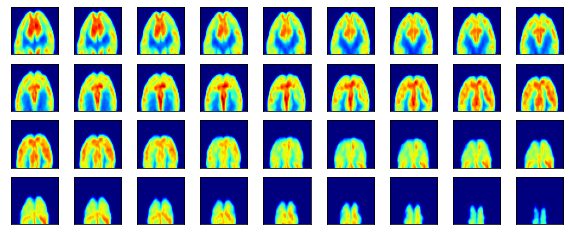

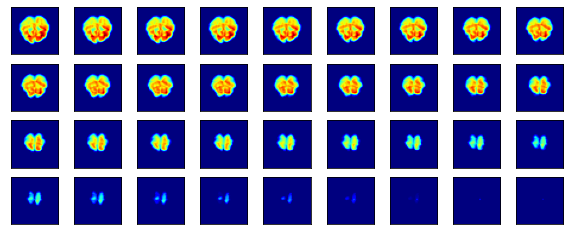

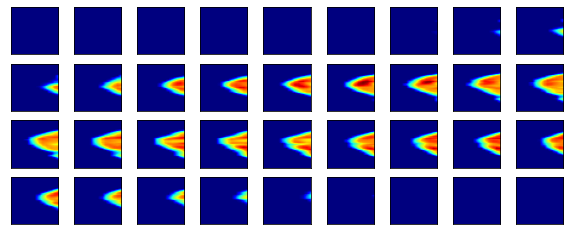

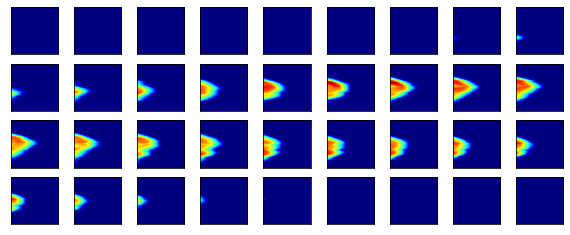

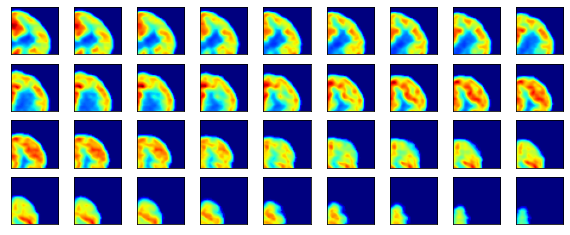

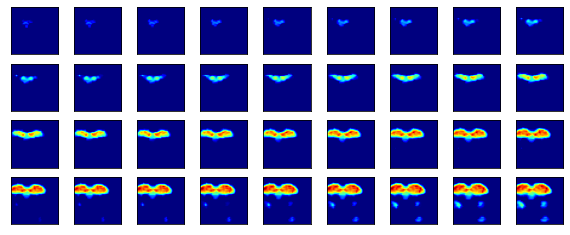

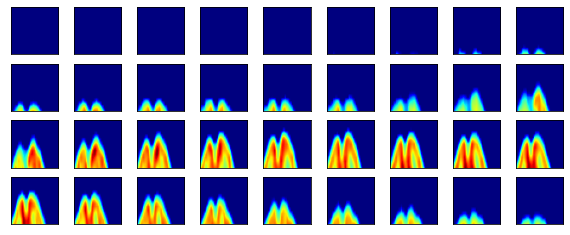

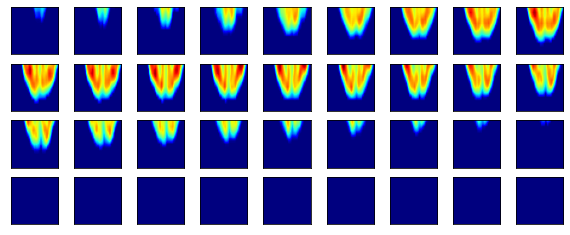

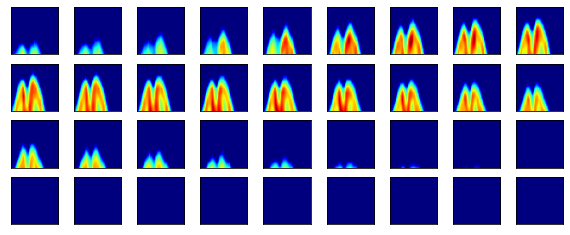

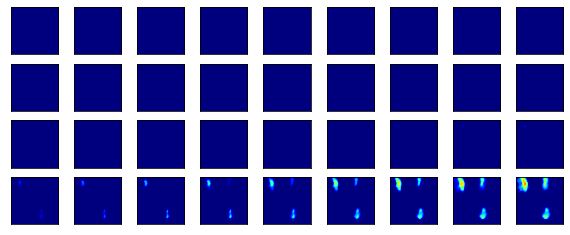

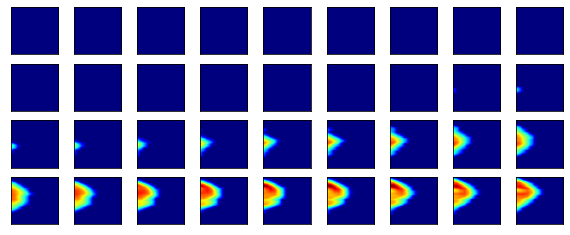

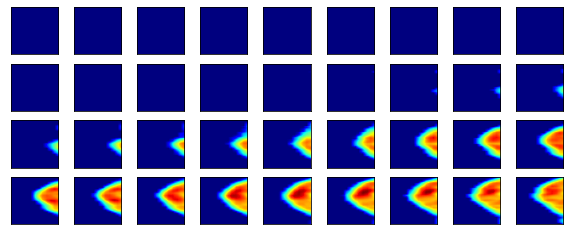

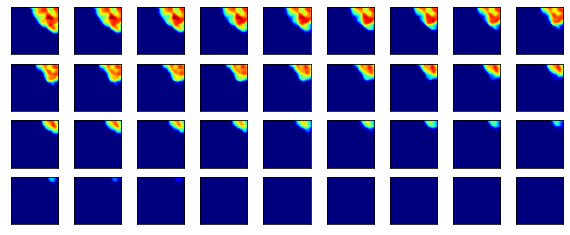

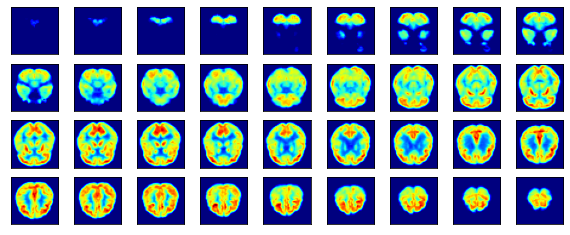

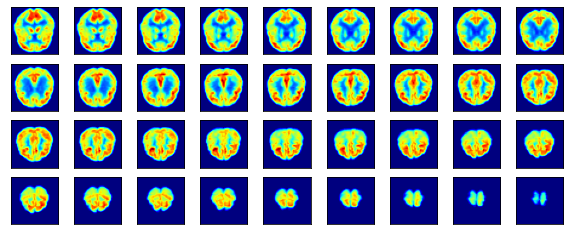

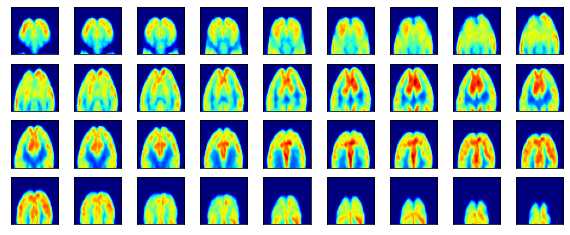

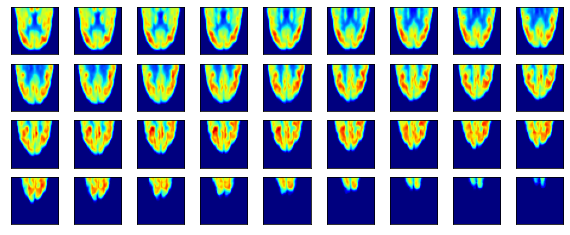

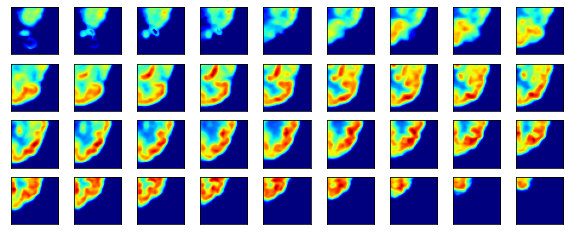

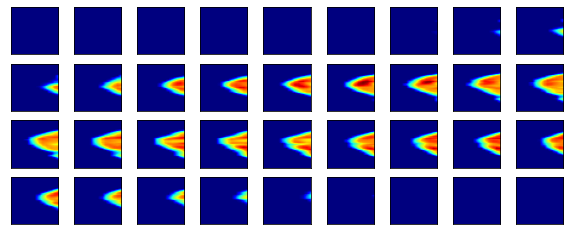

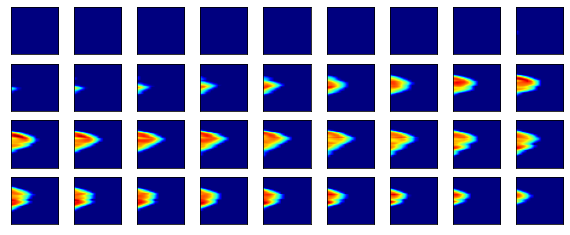

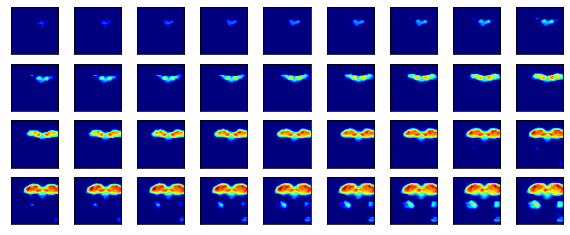

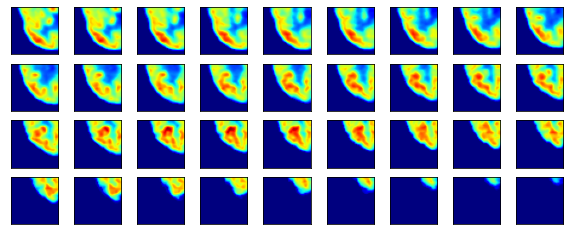

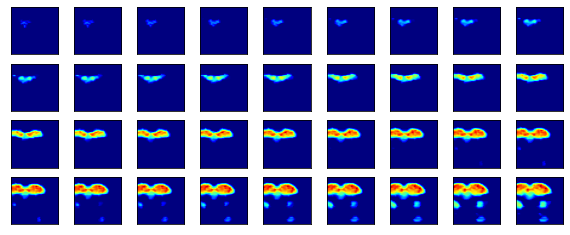

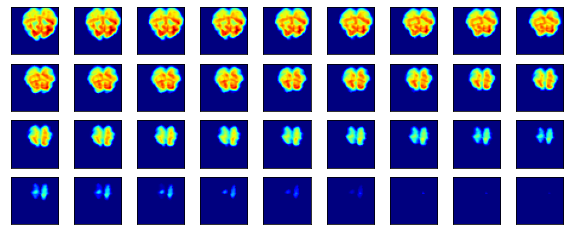

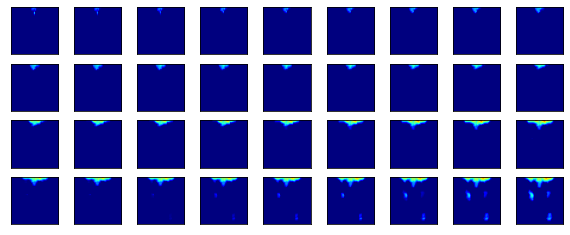

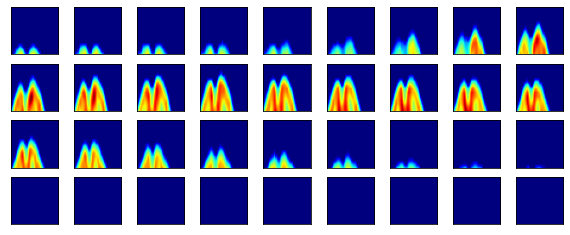

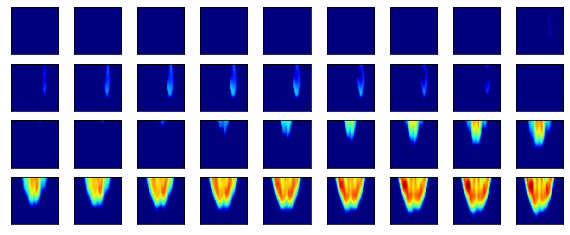

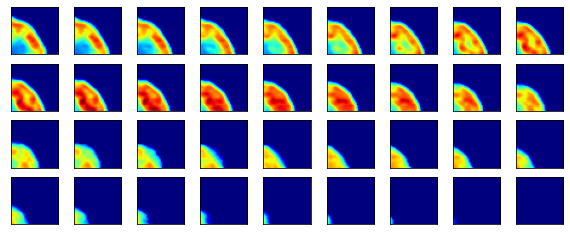

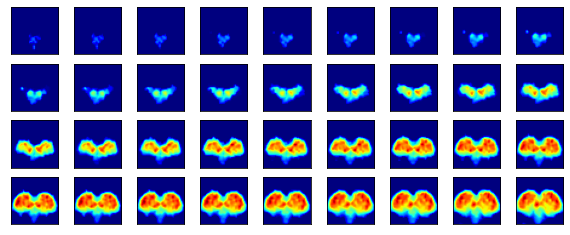

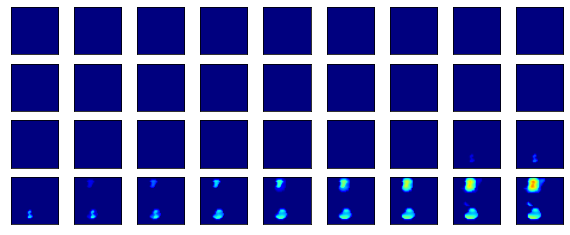

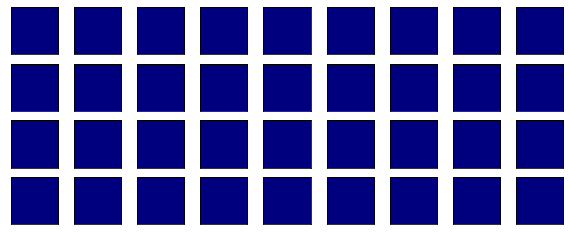

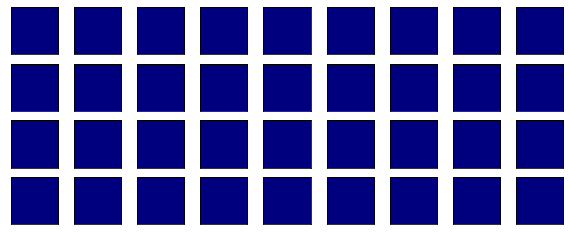

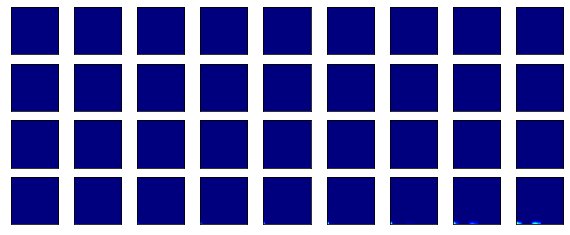

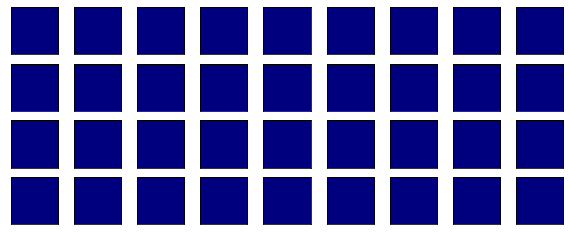

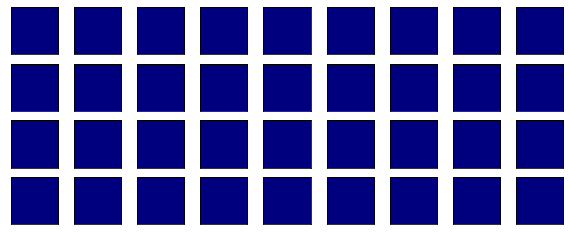

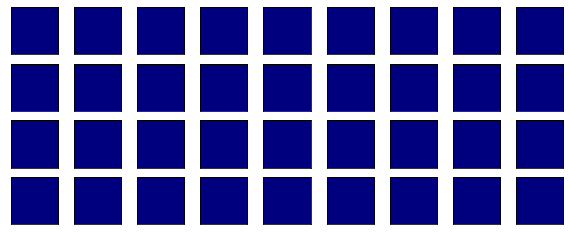

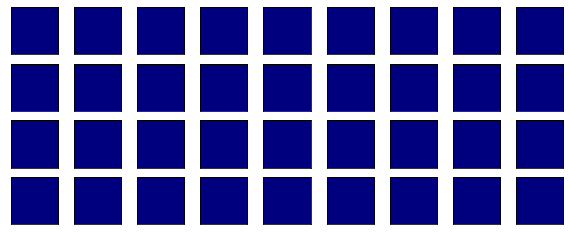

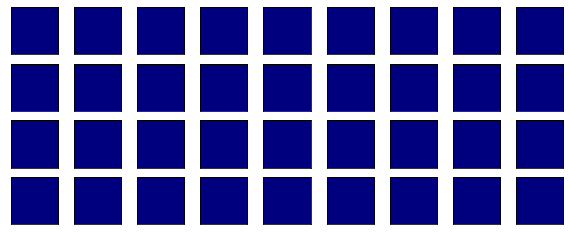

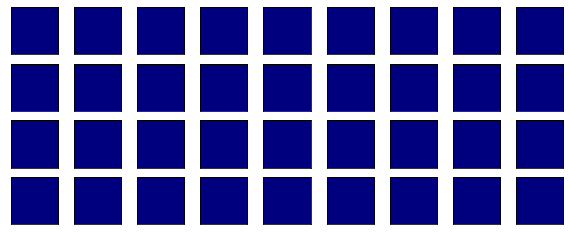

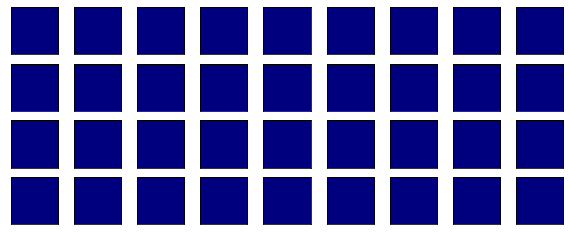

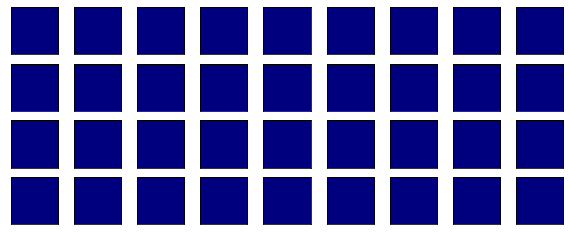

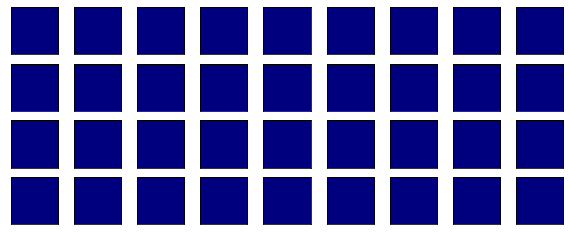

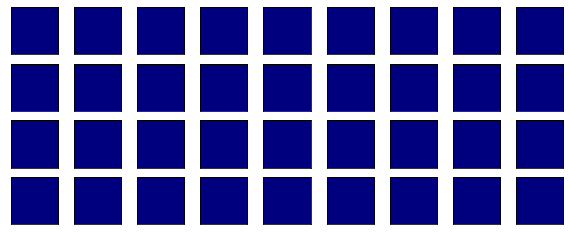

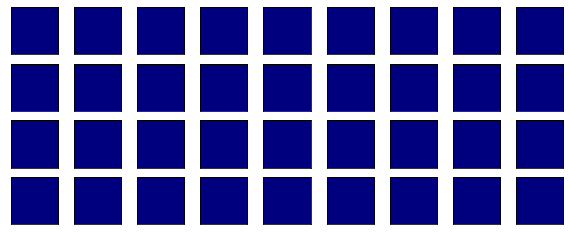

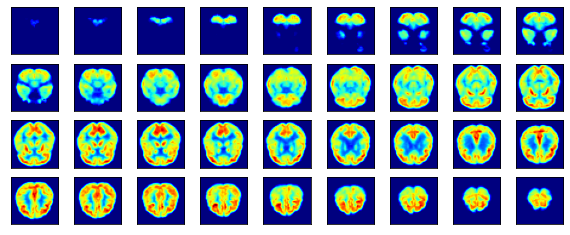

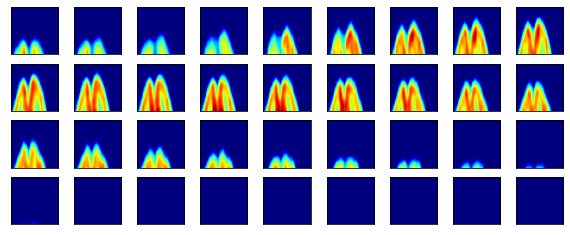

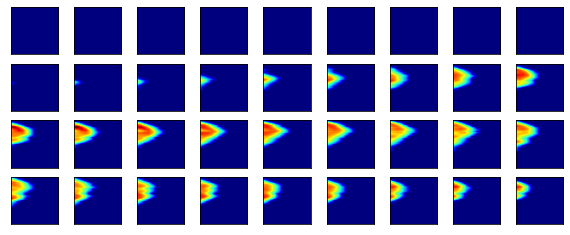

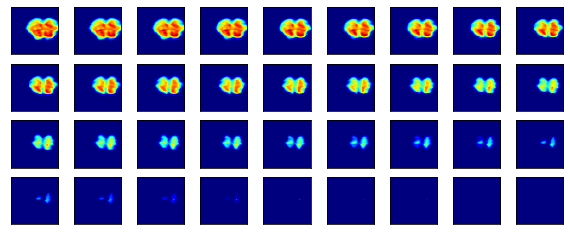

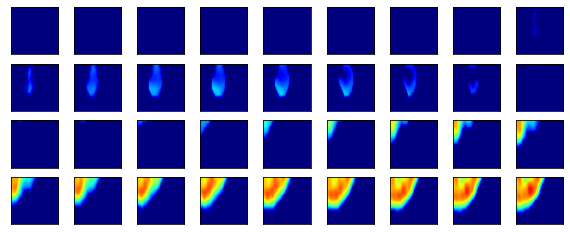

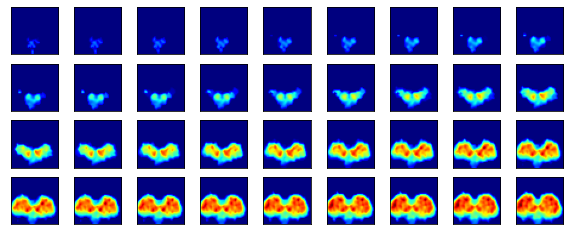

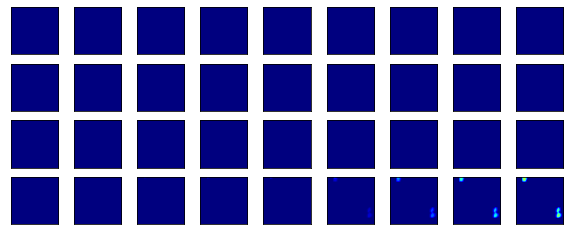

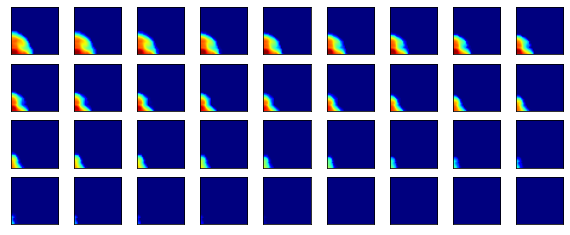

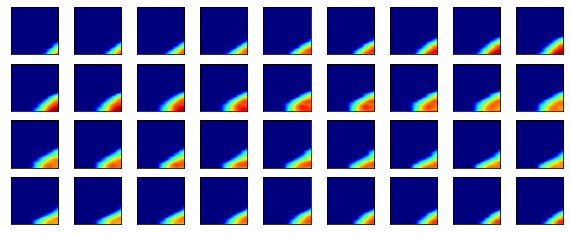

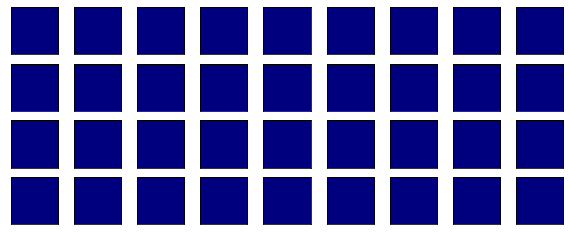

In [31]:
segmentation.roi_align(test_image, merge_interesting_boxes, displayed=True);

In [32]:
# Find coordinates of best boxes
for idx,x in zip(ad_bboxes.index, ad_bboxes['bbox_list'].values):
    if np.mean(x == hurr[0]) == 1: print(idx)

[autoreload of src.segmentation.segmentation failed: Traceback (most recent call last):
  File "/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 786, in exec_module
  File "<frozen importlib._bootstrap_external>", line 923, in get_code
  File "<frozen importlib._bootstrap_external>", line

KeyError: 'bbox_list'

In [ ]:
ad_bboxes.loc[3480]

In [ ]:
only_interesting

In [ ]:
""" https://www.analyticsvidsort_index/blog/2020/08/selecting-the-right-bounding-box-using-non-max-suppression-with-implementation/
Step 1: Select the box with highest objectiveness score [Replace with intensity?] - Calculate with nms (package availible in segmentation)
Step 2: Then, compare the overlap (intersection over union) of this box with other boxes 
Step 3: Remove the bounding boxes with overlap (intersection over union) >50%
Step 4: Then, move to the next highest objectiveness score
Step 5: Finally, repeat steps 2-4
"""